## environment setup and dataset download

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-multimodal-image-ct-and-mri' dataset.
Path to dataset files: /kaggle/input/brain-tumor-multimodal-image-ct-and-mri


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import random
from typing import List, Tuple

import torch

In [ ]:
# create function for reproducibility
def set_seed(seed: int = 42):
  random.seed(seed)
  np.random.seed(seed)

  torch.manual_seed(seed) # sets seed for random num generator
  torch.cuda.manual_seed_all(seed) # ensures consistent rng across all gpus
  # ensures reproducibility for convolutional operations when given same inputs and params
  torch.backends.cudnn.deterministic = True
  # used to achieve more reproducibile results as chosen algorithm will be less subject to variations
  torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
# confirm path structure
for subdir, dirs, files in os.walk(path):
  print(f"{subdir} → {len(files)} files")

/kaggle/input/brain-tumor-multimodal-image-ct-and-mri → 0 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset → 0 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images → 1 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images/Tumor → 3000 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images/Healthy → 2000 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor CT scan Images → 1 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor CT scan Images/Tumor → 2318 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor CT scan Images/Healthy → 2300 files


## build mri file list with labels

In [ ]:
# create dataframe of mri images with labels (healthy / tumor)

DATASET_DIR = os.path.join(path, "Dataset")
MRI_DIR = os.path.join(DATASET_DIR, "Brain Tumor MRI images")

# make sure mri_dir is a valid directory
assert os.path.isdir(MRI_DIR), f"Missing MRI directory: {MRI_DIR}"

def list_images_with_label(root_dir: str, label_dirs: List[str]) -> pd.DataFrame:
  rows = []
  for label in label_dirs:
    d = os.path.join(root_dir, label)
    if not os.path.isdir(d):
      print(f"Warning: {d} not found, skipping.")
      continue
    for f in os.listdir(d):
      if f.lower().endswith((".jpg", ".jpeg", ".png")):
        rows.append({
            "path": os.path.join(d, f),
            "label": label
        })
  return pd.DataFrame(rows)

mri_df = list_images_with_label(MRI_DIR, ["Healthy", "Tumor"])
print("MRI images:", len(mri_df))
mri_df.head()

MRI images: 5000


,path,label
0,/kaggle/input/brain-tumor-multimodal-image-ct-...,Healthy
1,/kaggle/input/brain-tumor-multimodal-image-ct-...,Healthy
2,/kaggle/input/brain-tumor-multimodal-image-ct-...,Healthy
3,/kaggle/input/brain-tumor-multimodal-image-ct-...,Healthy
4,/kaggle/input/brain-tumor-multimodal-image-ct-...,Healthy


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('path').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

label
Tumor      3000
Healthy    2000
Name: count, dtype: int64


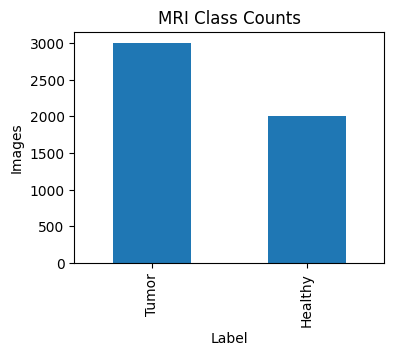

In [ ]:
# visual check of class counts (sanity check)
mri_counts = mri_df["label"].value_counts()
print(mri_counts)

plt.figure(figsize=(4,3))
mri_counts.plot(kind="bar")
plt.title("MRI Class Counts")
plt.xlabel("Label")
plt.ylabel("Images")
plt.show()

## split into train/val/test

In [ ]:
# split into train / val / test
from sklearn.model_selection import train_test_split

# map labels to integers for PyTorch
label_to_idx = {"Healthy": 0, "Tumor": 1}
mri_df["target"] = mri_df["label"].map(label_to_idx)

train_df, temp_df = train_test_split(
    mri_df, test_size=0.30, stratify=mri_df["target"], random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df["target"], random_state=42
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
for name, df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
  print(name, "class counts:\n", df["label"].value_counts(), "\n")

Train: 3500 Val: 750 Test: 750
Train class counts:
 label
Tumor      2100
Healthy    1400
Name: count, dtype: int64 

Val class counts:
 label
Tumor      450
Healthy    300
Name: count, dtype: int64 

Test class counts:
 label
Tumor      450
Healthy    300
Name: count, dtype: int64 



Note: The dataset doesn't include patient IDs. In order to avoid leakage as much as possible (patient-splitting), we can use a stratified split by filepath with fixed seed. We stratify to ensure that class proportions are preserved when splitting data

Split: 70 (train) / 15 (validation) / 15 (test)

## preprocessing steps + dataloaders

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# sample small subset of image paths, load each as grayscale, and scale pixel values to [0, 1]
# aggregate all pixels and compute dataset mean and std for use in transforms.Normalize(mean=[...], std=[...]) for standardization
def compute_mean_std(paths: List[str], sample_size: int = 512) -> Tuple[float, float]:
  # sample small subset of image paths for speed
  sample_paths = paths if len(paths) <= sample_size else random.sample(paths, sample_size)

  pixels = []
  for p in sample_paths:
    img = Image.open(p).convert("L") # grayscale image (single channel)
    arr = np.asarray(img, dtype=np.float32) / 255.0 # convert to array in [0, 1]
    pixels.append(arr.reshape(-1))

  # concatenate all sampled pixels into one long vector
  stacked = np.concatenate(pixels, axis=0)

  mean = float(stacked.mean())
  std = float(stacked.std())

  # clamp std to avoid dividing by extremely small values during normalizing
  std = float(max(std, 1e-6))

  return mean, std


mri_mean, mri_std = compute_mean_std(train_df["path"].tolist(), sample_size=1000)
print(f"MRI mean={mri_mean:.4f}, std={mri_std:.4f}")


# transforms: resize -> to tensor -> normalize
# stack grayscale into 3 channels
# prepares raw MRI images into a consistent, model-friendly format
# benefits: faster optimization convergence, reduced sensitivity to lighting / intensity
base_transform = transforms.Compose([
    # normalizing size so model learns content rather than scale differences
    transforms.Resize((224, 224)), # makes every image same spatial size
    transforms.ToTensor(), # converts to pytorch tensor [1,H,W] in [0,1]
    # (x - mean) / std so input distribution is centered and scaled
    transforms.Normalize(mean=[mri_mean], std=[mri_std]) # channel-wise standardization
])

# simple augmentation for training (small rotations / flips)
# TODO: test with adding contrast enhancement and brightness / contrast jitter
  # contrast enhancement: transforms.RandomAdjustSharpness(0.5)
  # brightness jitter: transforms.ColorJitter(brightness=0.10, contrast=0.10)
train_transform = transforms.Compose([
    # normalizing size so model learns content rather than scale differences
    transforms.Resize((224, 224)),
    # flips left to right. teaches model invariance to lateral orientation and can reduce overfitting
    # TODO: test different probabilities (like 0.2) if anotomical laterality could matter
    transforms.RandomHorizontalFlip(p=0.5),
    # rotates by a random angle in range +-10deg. teaches model robust to positioning differences
    transforms.RandomRotation(degrees=10),
    # augment PIL images first before ToTensor and Normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=[mri_mean], std=[mri_std])
    # repeat channels to 3 for typical CNNs
    # transforms.Lambda(lambda x: x.repeat(3,1,1))
])



class MRIDataset(Dataset):
  def __init__(self, df: pd.DataFrame, transform=None):
    self.paths = df["path"].tolist()
    self.targets = df["target"].tolist()
    self.transform = transform if transform is not None else base_transform

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, idx):
    p = self.paths[idx]
    y = self.targets[idx]
    img = Image.open(p).convert("L") # load as grayscale for normalization
    img = self.transform(img) # [1,H,W]
    # repeat channels to 3 for typical cnns
    img = img.repeat(3, 1, 1) # [3,H,W]
    return img, torch.tensor(y, dtype=torch.long)



# dataloaders
BATCH_SIZE = 64
train_ds = MRIDataset(train_df, transform=train_transform)
val_ds = MRIDataset(val_df, transform=base_transform)
test_ds = MRIDataset(test_df, transform=base_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


# sanity check batch
imgs, ys = next(iter(train_loader))
print("Batch shape:", imgs.shape, "Labels shape:", ys.shape)

MRI mean=0.1818, std=0.1961
Batch shape: torch.Size([64, 3, 224, 224]) Labels shape: torch.Size([64])


## cnn baseline and training loop

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
  # num_classes = 2 because we're using CrossEntropyLoss (expects class logits of size 2)
  def __init__(self, num_classes: int = 2):
    super().__init__()

    # 5 feature extractors
      # Conv2d: learns local spatial filters
      # BatchNorm2d: stabilizes training and reduces internal covariance shift
      # ReLu: introduce nonlinearity
      # MaxPool2d(2): downsample by 2, reducing H and W and adding translation invariance
    self.features = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
    )

    # classifer head
      # flattens the 256 * 7 * 7 features to a vector and applies two linear layers with dropout for regularization
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(256 * 7 * 7, 256),
        nn.ReLU(),
        nn.Dropout(0.3), # reduces overfitting
        nn.Linear(256, num_classes)
    )

  # passes input through feature extractor, then classifier and returns logit
  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=2).to(device)

# loss and optimizer
# compute invers frequency weights so minority classes have more impact in the loss
class_weights = torch.tensor([
    len(train_df) / (2 * (train_df["target"] == 0).sum()),
    len(train_df) / (2 * (train_df["target"] == 1).sum()),
], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

print("Device:", device, "Class weights:", class_weights.detach().cpu().numpy())

Device: cpu Class weights: [1.25      0.8333333]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | train_loss=0.8307 acc=0.763 f1=0.794 | val_loss=0.4360 acc=0.825 f1=0.864


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 02 | train_loss=0.3009 acc=0.875 f1=0.893 | val_loss=0.2260 acc=0.901 f1=0.914


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 03 | train_loss=0.2555 acc=0.894 f1=0.909 | val_loss=0.2481 acc=0.905 f1=0.922


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 04 | train_loss=0.2058 acc=0.914 f1=0.927 | val_loss=0.1912 acc=0.928 f1=0.938


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 05 | train_loss=0.1655 acc=0.937 f1=0.946 | val_loss=0.2747 acc=0.884 f1=0.894


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 06 | train_loss=0.1566 acc=0.937 f1=0.946 | val_loss=0.2059 acc=0.917 f1=0.934


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 07 | train_loss=0.1292 acc=0.952 f1=0.959 | val_loss=0.3042 acc=0.880 f1=0.890


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 08 | train_loss=0.0925 acc=0.965 f1=0.970 | val_loss=0.0951 acc=0.964 f1=0.970


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 09 | train_loss=0.0849 acc=0.966 f1=0.971 | val_loss=0.1059 acc=0.965 f1=0.971


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 10 | train_loss=0.0621 acc=0.978 f1=0.982 | val_loss=0.1414 acc=0.952 f1=0.961


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 11 | train_loss=0.0498 acc=0.983 f1=0.986 | val_loss=0.1607 acc=0.941 f1=0.953


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 12 | train_loss=0.0511 acc=0.980 f1=0.983 | val_loss=0.1000 acc=0.960 f1=0.966
Saved best model from epoch 9 with val F1=0.971


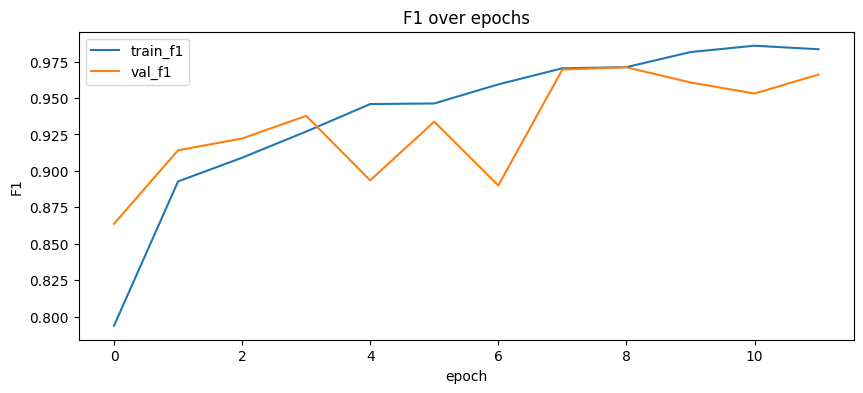

In [ ]:
# training loop with early stopping

from sklearn.metrics import accuracy_score, f1_score

EPOCHS = 12
best_val_f1 = 0.0
best_state = None

def run_epoch(loader, train: bool):
  if train:
    # enables dropout / batchnorm updates and gradients
    model.train()
  else:
    # freezes dropout / batchnorm for deterministic evaluation
    model.eval()

  total_loss = 0.0
  all_preds = []
  all_targets = []

  # disables autograd during validation to save memory and time
  with torch.set_grad_enabled(train):
    # batch iteration
    for imgs, ys in loader:
      imgs = imgs.to(device, non_blocking=True)
      ys = ys.to(device, non_blocking=True)
      logits = model(imgs)
      loss = criterion(logits, ys) # computes batch loss

      # performs optimization if training
      if train:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      total_loss += loss.item() * imgs.size(0) # sum per-sample loss across epoch
      preds = torch.argmax(logits, dim=1)
      all_preds.extend(preds.detach().cpu().numpy().tolist())
      all_targets.extend(ys.detach().cpu().numpy().tolist())

  avg_loss = total_loss / len(loader.dataset)
  acc = accuracy_score(all_targets, all_preds)
  f1 = f1_score(all_targets, all_preds, zero_division=1)
  return avg_loss, acc, f1

# for plotting
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "train_f1": [], "val_f1": []}

for epoch in range(1, EPOCHS + 1):
  tr_loss, tr_acc, tr_f1 = run_epoch(train_loader, train=True)
  val_loss, val_acc, val_f1 = run_epoch(val_loader, train=False)

  history["train_loss"].append(tr_loss); history["val_loss"].append(val_loss)
  history["train_acc"].append(tr_acc);   history["val_acc"].append(val_acc)
  history["train_f1"].append(tr_f1);     history["val_f1"].append(val_f1)

  # lowers learning rate when validation F1 plateaus (mode='max')
  scheduler.step(val_f1)
  print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} acc={tr_acc:.3f} f1={tr_f1:.3f} "
        f"| val_loss={val_loss:.4f} acc={val_acc:.3f} f1={val_f1:.3f}")

  # keep track of best_val_f1 for early stopping monitoring with f1 score
  if val_f1 > best_val_f1:
    best_val_f1 = val_f1
    best_state = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "epoch": epoch,
        "val_f1": val_f1,
    }


# save best model checkpoint
os.makedirs("checkpoints", exist_ok=True)
torch.save(best_state["model"], f"checkpoints/mri_simplecnn_best.pt")
print(f"Saved best model from epoch {best_state['epoch']} with val F1={best_state['val_f1']:.3f}")


# plot training curves
plt.figure(figsize=(10,4))
plt.plot(history["train_f1"], label="train_f1")
plt.plot(history["val_f1"], label="val_f1")
plt.title("F1 over epochs")
plt.xlabel("epoch"); plt.ylabel("F1")
plt.legend(); plt.show()

## evaluate on test set + metrics

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

     Healthy     0.9286    0.9967    0.9614       300
       Tumor     0.9977    0.9489    0.9727       450

    accuracy                         0.9680       750
   macro avg     0.9631    0.9728    0.9670       750
weighted avg     0.9700    0.9680    0.9682       750



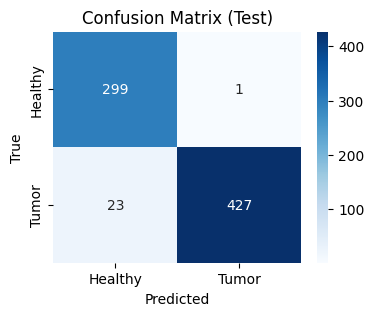

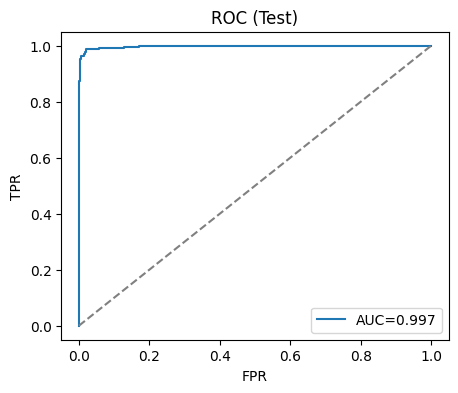

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# load best model
model.load_state_dict(torch.load("checkpoints/mri_simplecnn_best.pt", map_location=device))
model.eval()

all_targets = []
all_probs = []

with torch.no_grad():
    for imgs, ys in test_loader:
        imgs = imgs.to(device, non_blocking=True)
        ys = ys.to(device, non_blocking=True)
        logits = model(imgs)
        probs = F.softmax(logits, dim=1)[:, 1]  # probability of "Tumor"
        all_probs.extend(probs.cpu().numpy().tolist())
        all_targets.extend(ys.cpu().numpy().tolist())

# default threshold 0.5 for class
preds = (np.array(all_probs) >= 0.5).astype(int)

print(classification_report(all_targets, preds, target_names=["Healthy","Tumor"], digits=4))

cm = confusion_matrix(all_targets, preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy","Tumor"], yticklabels=["Healthy","Tumor"])
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# ROC Curve and AUC
fpr, tpr, thr = roc_curve(all_targets, all_probs)
auc = roc_auc_score(all_targets, all_probs)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC (Test)")
plt.legend()
plt.show()


Precision / Recall / F1:


*   Healthy:
    *   Precision = 0.929, Recall = 0.991, F1 = 0.961
    *   Model is near perfect when predicting Healthy and captures nearly all healthy cases
*   Tumor:
    *   Precision = 0.978, Recall = 0.949, F1 = 0.973
    *   Model is very precise on tumor predicions, with slightly lower sensitivity due to missed tumors
* Accuracy = 0.968
    *   Very strong, but accuracy can hide class-specific tradeoffs


Confusion Matrix:

*   1 Healthy misclassified as Tumor (false positive)
*   23 Tumor misclassified as Healthy (false negative)
*   Model almost never raises a false alarm on healthy scans, but it does miss about 5% of tumors (23/450 = 0.051)



ROC Curve:


*   AUC = 0.0997
*   Near perfect curve shows excellent separability
*   Tells us that we can adjust the decision threshold to trade a few more false positives to reduce false negatives



## save predictions and a few sample visualizations

Saved mri_test_predictions.csv with 750 rows


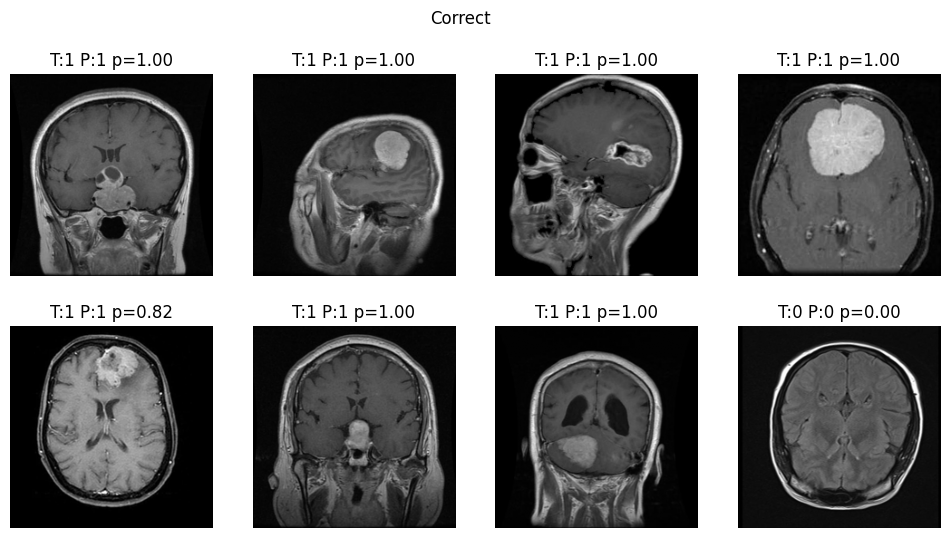

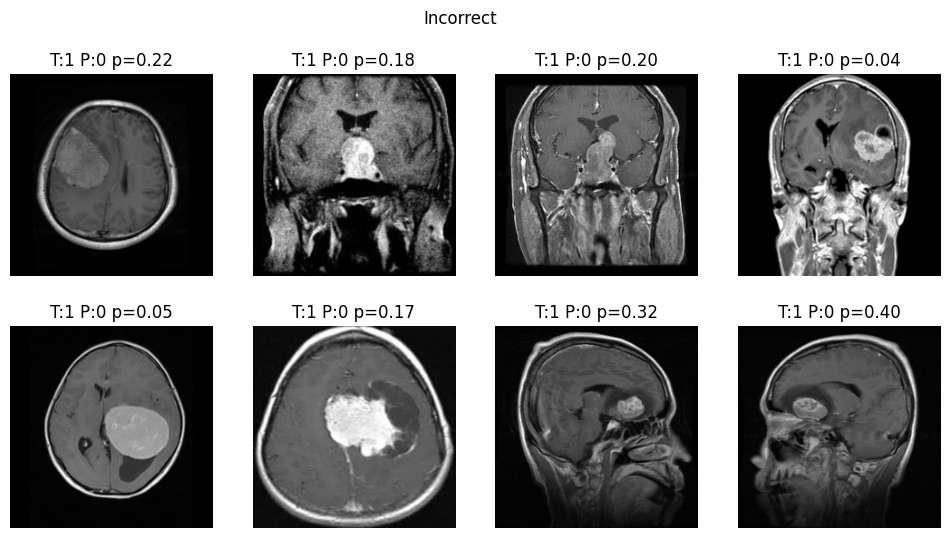

In [ ]:
# attach paths to predictions for test set
test_paths = test_df["path"].tolist()
pred_df = pd.DataFrame({
    "path": test_paths,
    "true": test_df["target"].tolist(),
    "prob_tumor": all_probs,
    "pred": preds.tolist()
})
pred_df.to_csv("mri_test_predictions.csv", index=False)
print("Saved mri_test_predictions.csv with", len(pred_df), "rows")

# show a small grid of correct vs incorrect predictions
def show_examples(df: pd.DataFrame, correct: bool, n: int = 8):
    subset = df[(df["pred"] == df["true"]) if correct else (df["pred"] != df["true"])].sample(min(n, len(df)), random_state=42)
    plt.figure(figsize=(12,6))
    for i, row in enumerate(subset.itertuples(), start=1):
        img = Image.open(row.path).convert("L").resize((224,224))
        plt.subplot(2, (n+1)//2, i)
        plt.imshow(img, cmap="gray")
        plt.title(f"T:{row.true} P:{row.pred} p={row.prob_tumor:.2f}")
        plt.axis("off")
    plt.suptitle("Correct" if correct else "Incorrect")
    plt.show()

show_examples(pred_df, correct=True, n=8)
show_examples(pred_df, correct=False, n=8)
